In [1]:
import os 
import pandas as pd
import numpy as np
import librosa
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from scipy import signal
import cv2


In [2]:
DATASET_DIR = './Dataset/train/audio/'

# ALL DATA

In [3]:
# # This block of code was insipired by the following link:
# # https://github.com/OldBonhart/TensorFlow_Speech_Recognition_Challenge/blob/master/Train___EfficientNet.ipynb
# labels = os.listdir(DATASET_DIR)
# data_map = {}
# for ind, label in enumerate(labels):
#     data_path = DATASET_DIR + label
#     data_map[data_path] = label, os.listdir(data_path), ind
# data_map.keys()
# data_map = {}
# for ind, label in enumerate(labels):
#     data_path = DATASET_DIR + label
#     data_map[ind] = label, os.listdir(data_path), ind
    
# df = pd.DataFrame(data_map.values(), 
#                   columns=["label_name", "path", "label"])
# df = df.set_index(['label_name', 'label'])
# df.reset_index(inplace=True)
# rows = []
# _ = df.apply(lambda row: [rows.append([row['label_name'], row['label'], nn]) 
#                          for nn in row.path], axis=1)
# df_new = pd.DataFrame(rows, columns=df.columns)
# df_new.to_csv(r'speech_commands_dataset_all_labels.csv', index=True)
# #print(df_new["label_name"].value_counts())
# df_new
# train_df, val_df = train_test_split(df_new, stratify=df_new['label'], test_size=0.1)
# train_df, test_df = train_test_split(train_df, stratify=train_df['label'], test_size=0.1)
# print(train_df.shape, val_df.shape)
# print(train_df.dtypes)
# print(train_df.head())

# DATA WITHOUT BACKGROUND:

In [4]:
# This block of code was insipired by the following link:
# https://github.com/OldBonhart/TensorFlow_Speech_Recognition_Challenge/blob/master/Train___EfficientNet.ipynb
labels = os.listdir(DATASET_DIR)
data_map = {}
for ind, label in enumerate(labels):
    data_path = DATASET_DIR + label
    data_map[data_path] = label, os.listdir(data_path), ind
data_map.keys()
data_map = {}
for ind, label in enumerate(labels):
    data_path = DATASET_DIR + label
    data_map[ind] = label, os.listdir(data_path), ind

df = pd.DataFrame(data_map.values(),
                  columns=["label_name", "path", "label"])
df = df.set_index(['label_name', 'label'])
df.reset_index(inplace=True)
background_df = df[df['label_name'] == '_background_noise_']
df = df[df['label_name'] != '_background_noise_']
element_to_remove = "_background_noise_"
if element_to_remove in labels:
    labels.remove(element_to_remove)
rows = []
_ = df.apply(lambda row: [rows.append([row['label_name'], row['label'], nn])
                         for nn in row.path], axis=1)
df_new = pd.DataFrame(rows, columns=df.columns)
df_new.to_csv(r'speech_commands_dataset_all_labels.csv', index=True)
df_new['label']=df_new['label'].apply(lambda x: x if x<12 else x-1)
data = df_new
train_df, val_df = train_test_split(df_new, stratify=df_new['label'], test_size=0.1)
train_df, test_df = train_test_split(train_df, stratify=train_df['label'], test_size=0.1)
print(train_df.shape, val_df.shape)
print(train_df.dtypes)
print(train_df.head())

(52423, 3) (6473, 3)
label_name    object
label          int64
path          object
dtype: object
      label_name  label                   path
60093        off     28  46a153d8_nohash_4.wav
5365         cat      2  f839238a_nohash_0.wav
64194       four     29  2bd2cad5_nohash_0.wav
26584       stop     11  f804cbb3_nohash_0.wav
51939        six     24  3bc21161_nohash_1.wav


In [5]:
NUM_CLASSES = len(labels)

In [6]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

# Model

In [13]:
import logging

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader

class TransformerModel(nn.Module):
    def __init__(self, input_channels, hidden_size, num_layers, num_heads, num_classes, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Conv2d(input_channels, hidden_size, kernel_size=3, padding=1)
        self.transformer_layer = nn.TransformerEncoderLayer(
            hidden_size, num_heads, dim_feedforward=4*hidden_size,
            batch_first=True, dropout=dropout)  # Set batch_first to True
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers)
        self.fc = nn.Linear(hidden_size * 32 * 32, num_classes)



    def forward(self, x):
        x = self.embedding(x)
        logging.debug(f"After embedding: {x.size()}")  # Log size after embedding
        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, channels, height * width).permute(0, 2, 1)  # Reshape and permute
        logging.debug(f"After reshape and permute: {x.size()}")  # Log size after reshape and permute
        x = self.transformer(x)
        logging.debug(f"After transformer: {x.size()}")  # Log size after transformer
        x = torch.mean(x, dim=1)  # Average over sequence length
        logging.debug(f"After mean: {x.size()}")  # Log size after mean
        x = self.fc(x)
        logging.debug(f"After fc: {x.size()}")  # Log size after fc
        return x

# Parameters
input_channels = 1
input_height = 32
input_width = 32
hidden_size = 80
num_layers = 2
num_heads = 4
dropout = 0.1

# Initialize model
model = TransformerModel(input_channels, hidden_size, num_layers, num_heads, NUM_CLASSES)


In [14]:
batch_size = 64
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def right_pad(waveform, minimal_length):
    length_signal = waveform.shape[0]
    if length_signal < minimal_length:
        missing_samples = minimal_length - length_signal
        last_dim_padding = (0, missing_samples)
        waveform = torch.nn.functional.pad(waveform, last_dim_padding)
    return waveform

class SpeechDataset(Dataset):
    def __init__(self, dataframe, num_classes, transform=None):
        self.data = dataframe
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label_name = self.data.iloc[idx, 0]  # Assuming label is in the first column
        label = self.data.iloc[idx, 1]  # Assuming label is in the second column
        path = self.data.iloc[idx, 2]    # Assuming path is in the third column
        signal_path = DATASET_DIR + label_name + '/' + path
        waveform, sample_rate = librosa.load(signal_path, mono=True, sr=None)
        # waveform = torch.tensor(waveform, dtype=torch.float32)
        # waveform = right_pad(waveform, 16000)
        # waveform = waveform.unsqueeze(0)
        # label_tensor = F.one_hot(torch.tensor(label), num_classes=self.num_classes).float()
        # sample = {'waveform': waveform, 'label': label_tensor} 
        freqs, times, spectrogram = log_specgram(waveform, sample_rate)
        img = cv2.resize(spectrogram, (32, 32))
        img = np.divide((img - np.mean(img)), np.std(img), out=img, where=np.std(img) != 0)
        img = np.expand_dims(img, axis=0)
        img_tensor = torch.from_numpy(img.astype(np.float32))
        label_tensor = F.one_hot(torch.tensor(label), num_classes=self.num_classes).float()

        return {'waveform': img_tensor, 'label': label_tensor} 

In [15]:
# num_classes = len(train_df["label"].unique())
train_dataset = SpeechDataset(dataframe=train_df, num_classes=NUM_CLASSES, transform=None)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = SpeechDataset(dataframe=val_df, num_classes=NUM_CLASSES, transform=None)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = SpeechDataset(dataframe=test_df, num_classes=NUM_CLASSES, transform=None)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [16]:
print(train_dataset[0]['waveform'].shape)
print(train_dataset[0]['label'].shape)

torch.Size([1, 32, 32])
torch.Size([30])


In [17]:
num_epochs = 2

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, targets = batch['waveform'], batch['label']
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss
    avg_loss = total_loss / len(train_loader)
    print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # No need to compute gradients during validation
        for val_batch in val_loader:
            val_inputs, val_targets = val_batch['waveform'], val_batch['label']
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            total_val_loss += val_loss.item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    print(f'Validation - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_val_loss:.4f}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x80 and 81920x30)

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix

model.eval()
all_targets = []
all_predicted = []

with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch['waveform'], batch['label']
        outputs = model(inputs)
        targets = torch.argmax(targets, dim=1)  # Assuming targets is one-hot encoded, convert it to class indices
        _, predicted = torch.max(outputs, 1)
        
        # Append targets and predicted values to lists
        all_targets.extend(targets.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

# Create confusion matrix
conf_matrix = confusion_matrix(all_targets, all_predicted)



KeyboardInterrupt: 

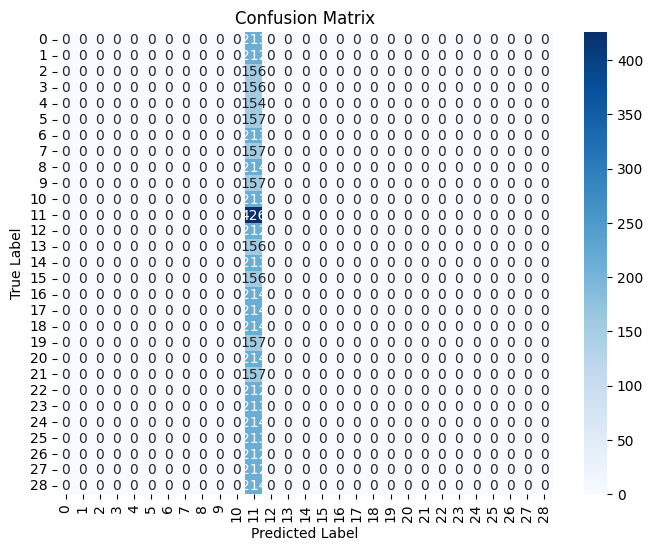

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


(array([213., 212., 156., 156., 154.,   0., 157., 213., 157., 214., 157.,
          0., 213., 426., 212.,   0., 156.,   0., 213., 156., 214., 214.,
        214.,   0., 157., 214., 157., 212., 213.,   0., 214., 213., 212.,
        212., 214.]),
 array([ 0.        ,  0.82857143,  1.65714286,  2.48571429,  3.31428571,
         4.14285714,  4.97142857,  5.8       ,  6.62857143,  7.45714286,
         8.28571429,  9.11428571,  9.94285714, 10.77142857, 11.6       ,
        12.42857143, 13.25714286, 14.08571429, 14.91428571, 15.74285714,
        16.57142857, 17.4       , 18.22857143, 19.05714286, 19.88571429,
        20.71428571, 21.54285714, 22.37142857, 23.2       , 24.02857143,
        24.85714286, 25.68571429, 26.51428571, 27.34285714, 28.17142857,
        29.        ]),
 <BarContainer object of 35 artists>)

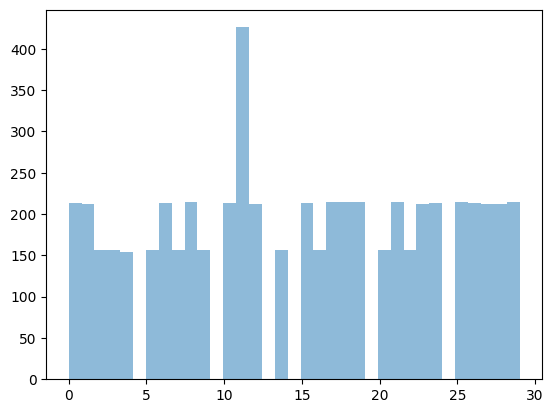

In [11]:
plt.hist(all_targets, bins=35, alpha=0.5, label='targets')